In [1]:
import polars as pl
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
#Conexión a la base de datos
conn_params = {
    "dbname": "postcodes_db",
    "user": "postgres",
    "password": "postgres",
    "host": "localhost",
    "port": "5432"
}

conn = psycopg2.connect(**conn_params)

# Análisis Códigos postales

En este apartado obtendremos y organizaremos información sobre cuales son los códigos postales, regiones y países más comunes.

In [3]:
postcodes_query = """
    SELECT 
        pd.postcode,
        pd.region,
        pd.country,
        COUNT(DISTINCT cp.coordinate_id) as coordinate_count,
        AVG(cp.distance) as avg_distance
    FROM postcode_details pd
    JOIN coordinates_postcodes cp ON pd.id = cp.postcode_id
    GROUP BY pd.postcode, pd.region, pd.country
    ORDER BY coordinate_count DESC
"""

In [4]:
postcode_df = pl.read_database(postcodes_query, conn)

In [5]:
print(postcode_df.head(10))

shape: (10, 5)
┌──────────┬────────────┬──────────┬──────────────────┬──────────────┐
│ postcode ┆ region     ┆ country  ┆ coordinate_count ┆ avg_distance │
│ ---      ┆ ---        ┆ ---      ┆ ---              ┆ ---          │
│ str      ┆ str        ┆ str      ┆ i64              ┆ f64          │
╞══════════╪════════════╪══════════╪══════════════════╪══════════════╡
│ G2 2SA   ┆ null       ┆ Scotland ┆ 45               ┆ 45.079585    │
│ G2 2QZ   ┆ null       ┆ Scotland ┆ 43               ┆ 43.082019    │
│ G1 2SB   ┆ null       ┆ Scotland ┆ 42               ┆ 48.397607    │
│ CW11 1GB ┆ North West ┆ England  ┆ 42               ┆ 59.519192    │
│ AB11 6BB ┆ null       ┆ Scotland ┆ 42               ┆ 62.84173     │
│ G2 4RL   ┆ null       ┆ Scotland ┆ 41               ┆ 53.52095     │
│ G2 2SD   ┆ null       ┆ Scotland ┆ 41               ┆ 44.23604     │
│ G2 6LU   ┆ null       ┆ Scotland ┆ 40               ┆ 50.667667    │
│ G2 7JZ   ┆ null       ┆ Scotland ┆ 40               ┆ 62.702

In [6]:
# Agrupación por región y país
regions_df = postcode_df.group_by(['region', 'country']).agg([
                pl.col('coordinate_count').sum().alias('coordinate_count'),
                pl.col('avg_distance').mean().alias('avg_distance')
            ]).sort('coordinate_count', descending=True)

In [7]:
# Agrupación por país
countries_df = postcode_df.group_by('country').agg([
                    pl.sum('coordinate_count').alias('coordinate_count'),
                    pl.mean('avg_distance').alias('avg_distance')
                ]).sort('coordinate_count', descending=True)

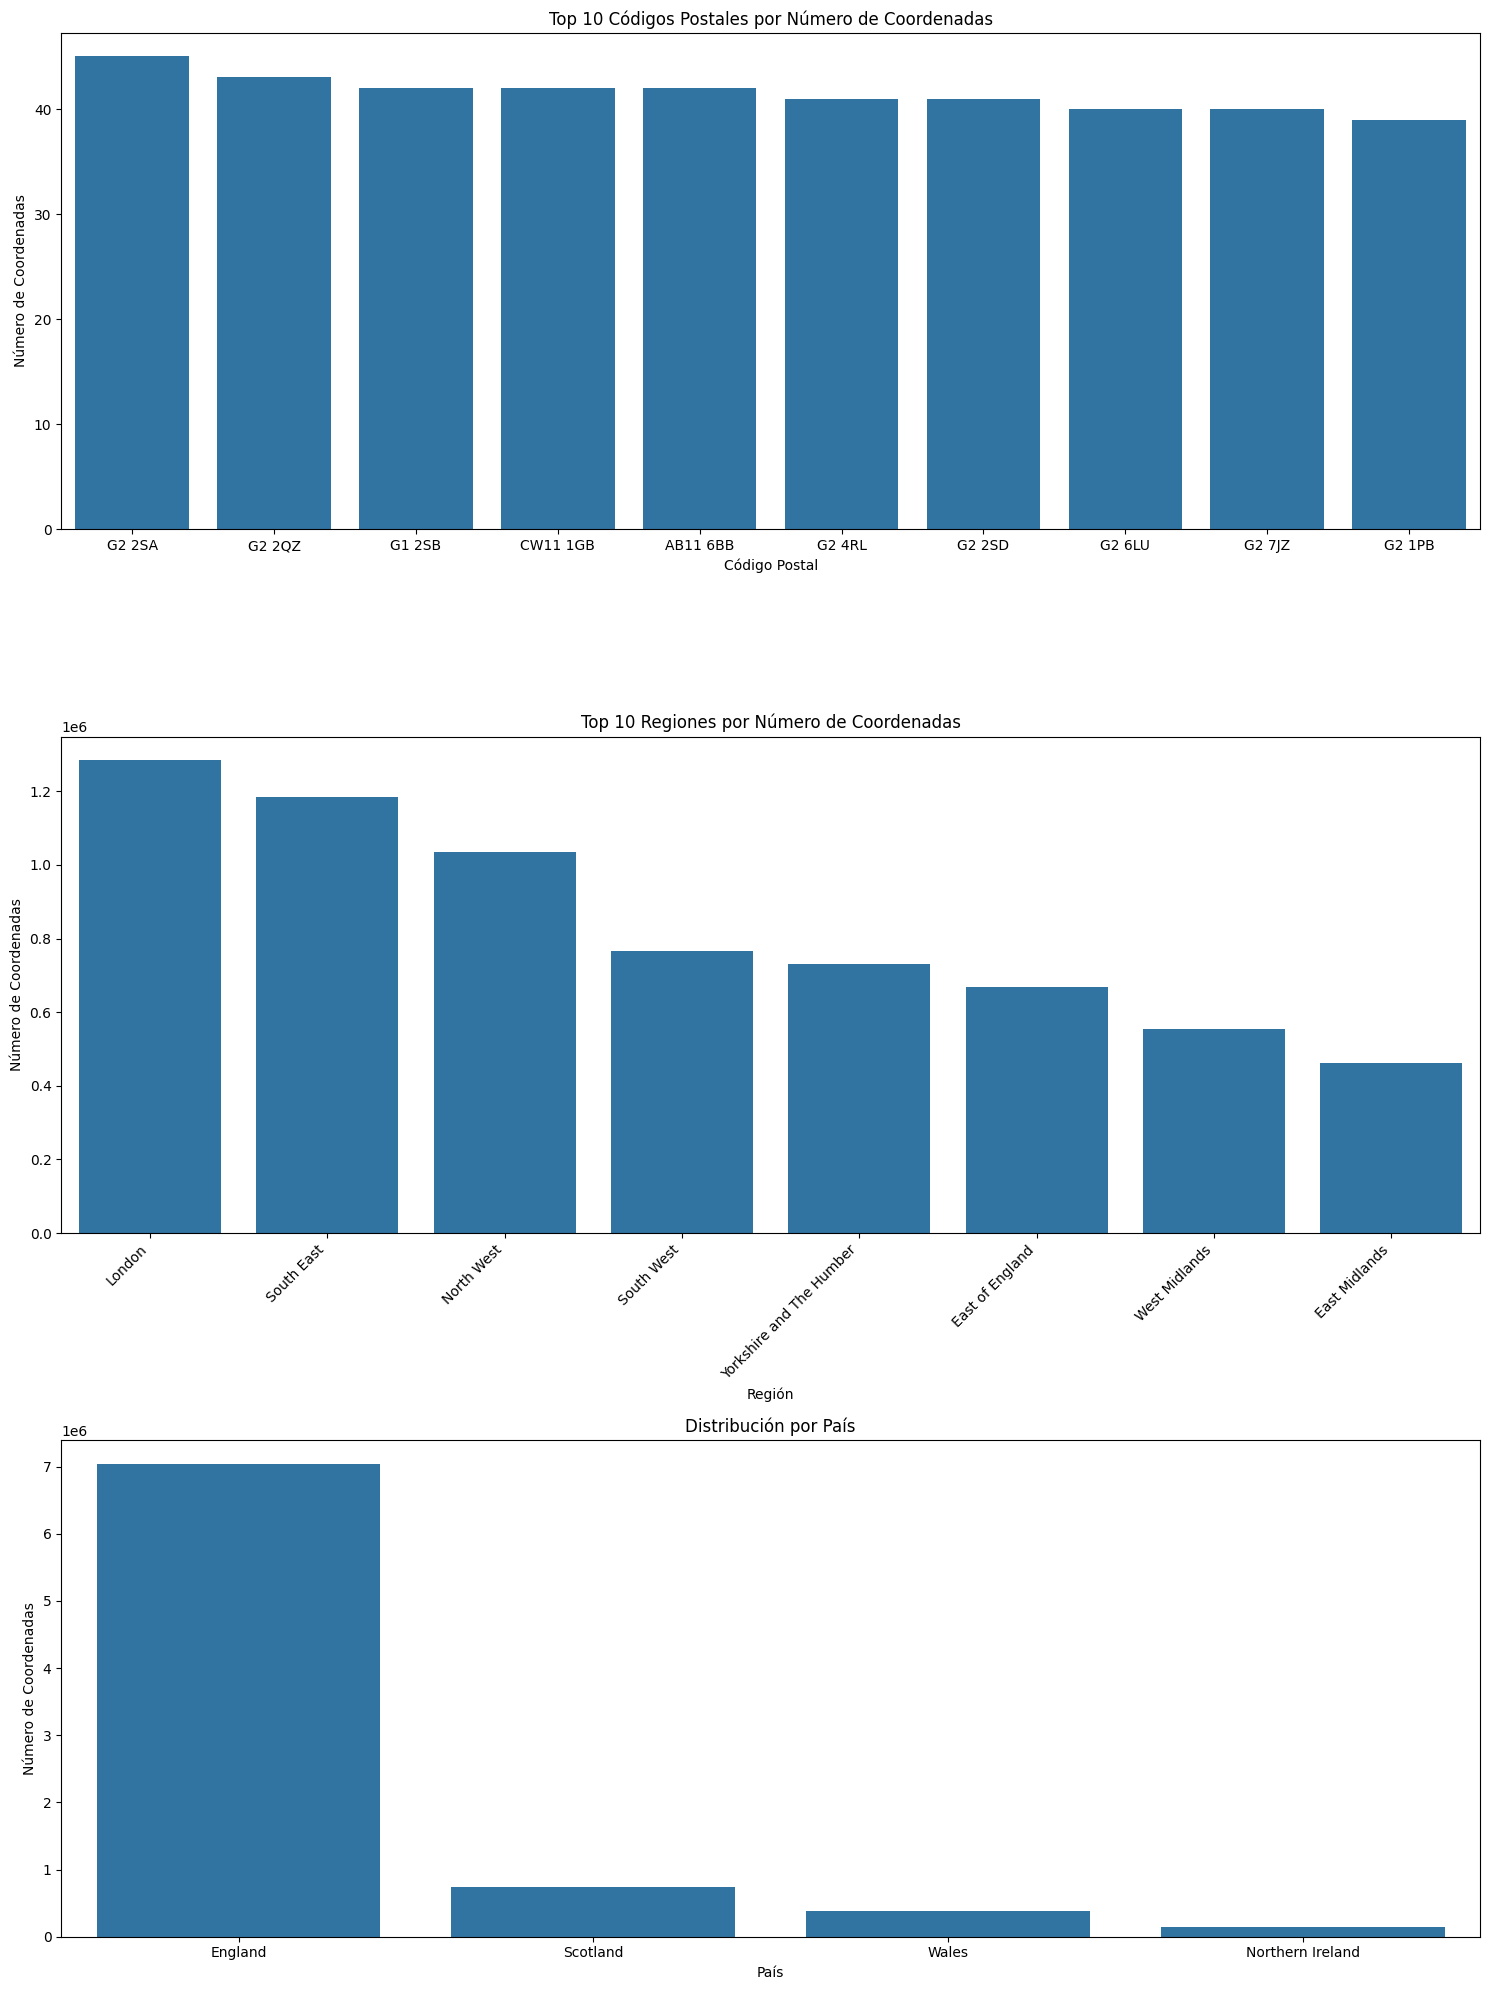

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

# 1. Top 10 Códigos Postales
sns.barplot(
    data=postcode_df.head(10).to_pandas(),
    x='postcode',
    y='coordinate_count',
    ax=ax1
)
ax1.set_title('Top 10 Códigos Postales por Número de Coordenadas')
ax1.set_xlabel('Código Postal')
ax1.set_ylabel('Número de Coordenadas')

# 2. Regiones
sns.barplot(
    data=regions_df.head(10),
    x='region',
    y='coordinate_count',
    ax=ax2
)
ax2.set_title('Top 10 Regiones por Número de Coordenadas')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
ax2.set_xlabel('Región')
ax2.set_ylabel('Número de Coordenadas')

# 3. Países
sns.barplot(
    data=countries_df,
    x='country',
    y='coordinate_count',
    ax=ax3
)
ax3.set_title('Distribución por País')
ax3.set_xlabel('País')
ax3.set_ylabel('Número de Coordenadas')

plt.savefig('../imgs/distribucion_postcodes.png', bbox_inches='tight', dpi=300)

plt.tight_layout()
plt.show()

De acuerdo con las 3 graficas podriamos suponer que los codigos postales más frecuentes se encuentran en London, England. Pero al verificar el detalle de la tabla del top 10 encontramos que 9 de 10 se encuentran en Scotland a pesar de que tenemos una densidad de codigos más alta en England.

Esto se puede deber a que el conjunto de datos de codigos postales de England es más diverso, mientras que los puntos de Scotland se concentran en los codigos postales encontrados en el top 10.

In [9]:
postcode_df.head(10).write_csv('../data/top_postcodes.csv')

# Estadisticos calidad

Evaluaremos la calidad de los datos enriquecidos en base a los errores obtenidos al llamar la API de postcodes.io

In [10]:
stats_query = """
    WITH error_counts AS (
        SELECT 
            COUNT(*) as total_errors,
            COUNT(CASE WHEN error_type = 'NO_RESULTS' THEN 1 END) as no_results_errors,
            COUNT(CASE WHEN error_type = 'API_ERROR' THEN 1 END) as api_errors
        FROM error_logs
    ),
    coord_counts AS (
        SELECT 
            COUNT(DISTINCT rc.id) as total_coordinates,
            COUNT(DISTINCT cp.coordinate_id) as matched_coordinates,
            COUNT(DISTINCT rc.id) - COUNT(DISTINCT cp.coordinate_id) as unmatched_coordinates,
            COUNT(DISTINCT pd.postcode) as unique_postcodes,
            COUNT(DISTINCT pd.region) as unique_regions,
            COUNT(DISTINCT pd.country) as unique_countries
        FROM raw_coordinates rc
        LEFT JOIN coordinates_postcodes cp ON rc.id = cp.coordinate_id
        LEFT JOIN postcode_details pd ON cp.postcode_id = pd.id
    )
    SELECT 
        c.*,
        ROUND((c.matched_coordinates::float/total_coordinates*100)::numeric, 2) as match_percentage,
        ROUND((c.unmatched_coordinates::float/total_coordinates*100)::numeric, 2) as unmatch_percentage,
        e.*,
        ROUND((e.total_errors::float/total_coordinates*100)::numeric, 2) as total_errors_percentage,
        ROUND((e.no_results_errors::float/total_coordinates*100)::numeric, 2) as no_results_errors_percentage,
        ROUND((e.api_errors::float/total_coordinates*100)::numeric, 2) as api_errors_percentage
    FROM coord_counts c
    CROSS JOIN error_counts e
"""

In [11]:
stats_df = pl.read_database(stats_query, conn)

In [12]:
display(stats_df.head())

total_coordinates,matched_coordinates,unmatched_coordinates,unique_postcodes,unique_regions,unique_countries,match_percentage,unmatch_percentage,total_errors,no_results_errors,api_errors,total_errors_percentage,no_results_errors_percentage,api_errors_percentage
i64,i64,i64,i64,i64,i64,"decimal[*,2]","decimal[*,2]",i64,i64,i64,"decimal[*,2]","decimal[*,2]","decimal[*,2]"
2020643,1967392,53251,1729211,9,4,97.36,2.64,52198,49302,2896,2.58,2.44,0.14


In [13]:
stats_df.write_csv('../data/postcode_quality_statistics.csv')

# Analisis de errores

Evaluaremos la cantidad de errores obtenidos, y verificaremos si en algún punto hubo una posible caida del sericio API.

In [14]:
error_analisys_query = """
    WITH unmatched AS (
        SELECT rc.id
        FROM raw_coordinates rc
        LEFT JOIN coordinates_postcodes cp ON rc.id = cp.coordinate_id
        WHERE cp.coordinate_id IS NULL
    )
    SELECT 
        el.error_type,
        COUNT(*) as error_count,
        ROUND((COUNT(*)::float / (SELECT COUNT(*) FROM unmatched) * 100)::numeric, 2) as error_percentage
    FROM unmatched u
    JOIN error_logs el ON u.id = el.coordinate_id
    GROUP BY el.error_type
    ORDER BY error_count DESC
"""

In [15]:
error_analisys = pl.read_database(error_analisys_query, conn)

In [16]:
print(error_analisys)

shape: (2, 3)
┌────────────┬─────────────┬──────────────────┐
│ error_type ┆ error_count ┆ error_percentage │
│ ---        ┆ ---         ┆ ---              │
│ str        ┆ i64         ┆ decimal[*,2]     │
╞════════════╪═════════════╪══════════════════╡
│ NO_RESULTS ┆ 49302       ┆ 92.58            │
│ API_ERROR  ┆ 2896        ┆ 5.44             │
└────────────┴─────────────┴──────────────────┘


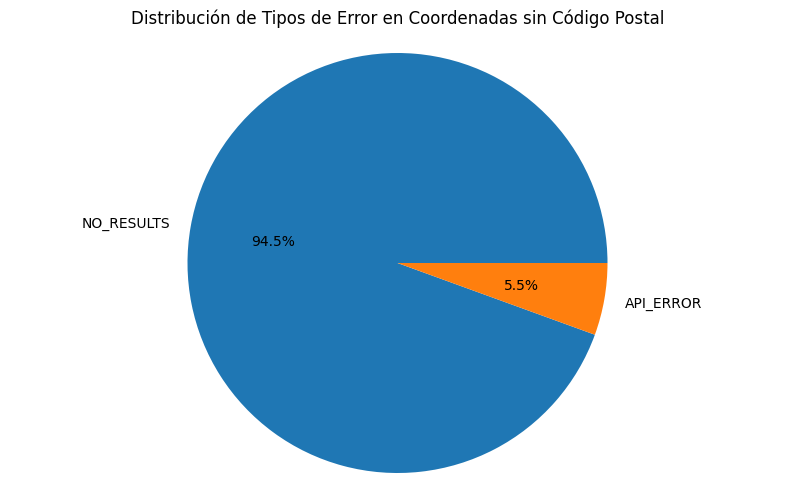

<Figure size 640x480 with 0 Axes>

In [17]:
plt.figure(figsize=(10, 6))
plt.pie(error_analisys['error_count'], 
        labels=error_analisys['error_type'],
        autopct='%1.1f%%')
plt.title('Distribución de Tipos de Error en Coordenadas sin Código Postal')
plt.axis('equal')
plt.show()
plt.savefig('../imgs/distribucion_errores.png', bbox_inches='tight', dpi=300)

Podemos evidenciar que la mayoria más del 90% de los errores NO_RESULTS, se debio a que la coordenada buscada se encuentra por fuera del rango de los codigos postales de la API, por ello hemos de supone que son coordenadas por fuera de UK.

In [18]:
error_ts_query = """
    SELECT 
        DATE_TRUNC('hour', created_at) as time_bucket,
        error_type,
        COUNT(*) as error_count
    FROM error_logs
    GROUP BY DATE_TRUNC('hour', created_at), error_type
    ORDER BY time_bucket
"""

In [19]:
error_ts = pl.read_database(error_ts_query, conn)

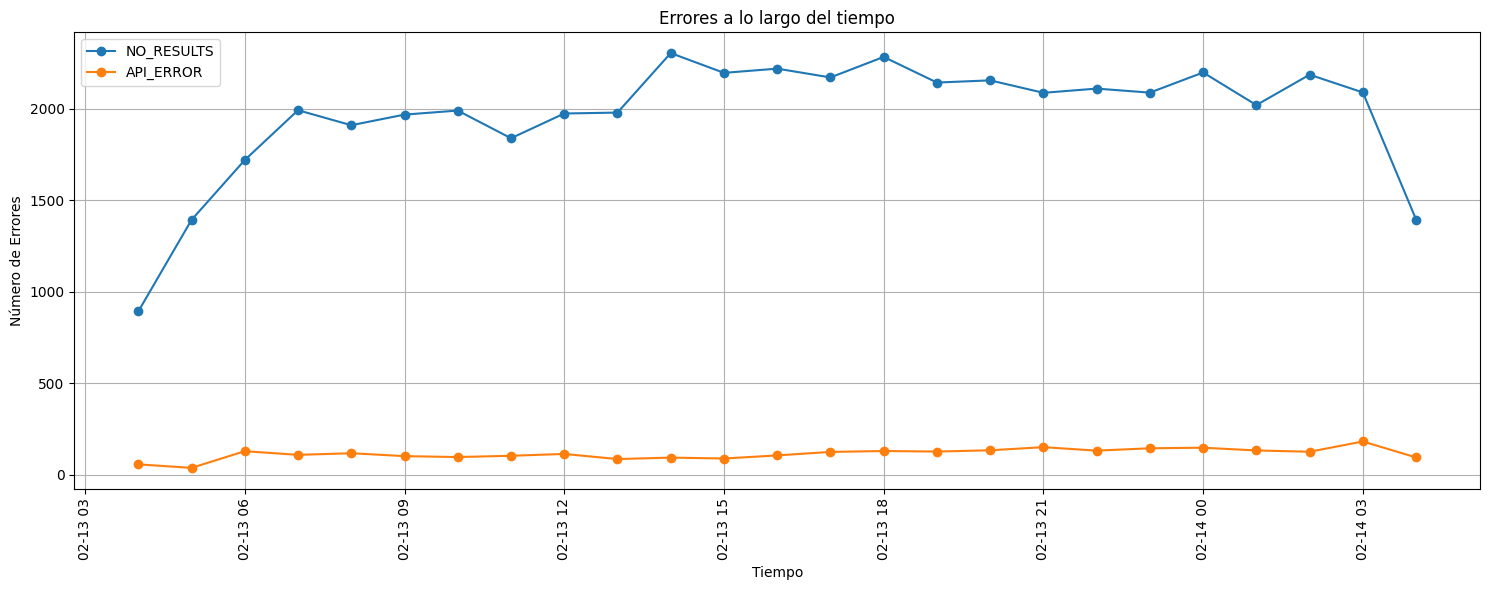

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(15, 6))

for error_type in error_ts['error_type'].unique():
    error_data = error_ts.filter(pl.col('error_type') == error_type)
    plt.plot(
        error_data['time_bucket'], 
        error_data['error_count'],
        label=error_type,
        marker='o'
    )

plt.title('Errores a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Número de Errores')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90)
plt.tight_layout()

plt.show()
plt.savefig('../imgs/errores_tiempo.png', bbox_inches='tight', dpi=300)

## Distancias

Evaluamos la distribucion de distancia en la que la coordenada se encuentra del codigo postal.

In [21]:
distance_query = """
    SELECT distance 
    FROM coordinates_postcodes
"""

In [22]:
distance_df = pl.read_database(distance_query, conn)

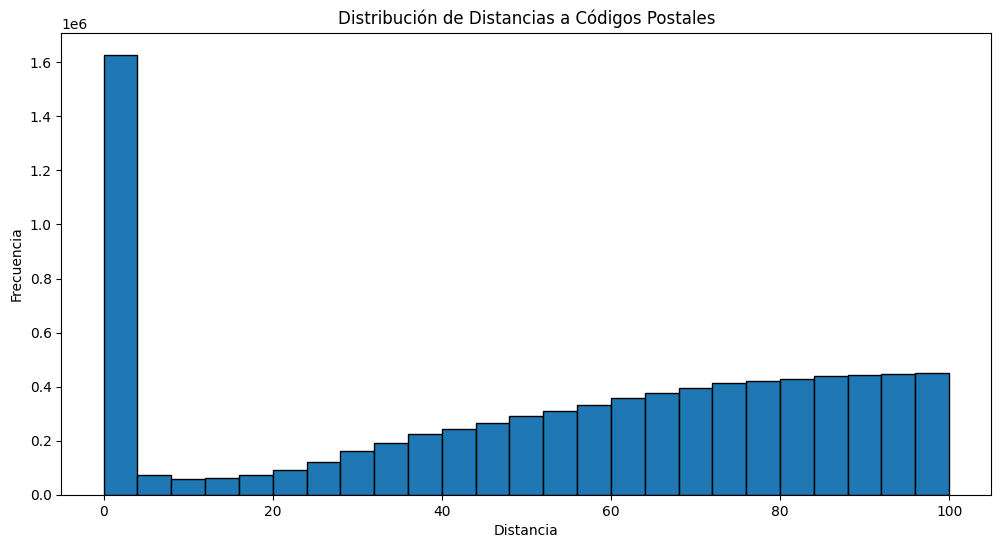

<Figure size 640x480 with 0 Axes>

In [23]:
plt.figure(figsize=(12, 6))
plt.hist(distance_df['distance'], bins=25, edgecolor='black')
plt.title('Distribución de Distancias a Códigos Postales')
plt.xlabel('Distancia')
plt.ylabel('Frecuencia')
plt.show()
plt.savefig('../imgs/distribucion_distancias.png', bbox_inches='tight', dpi=300)

En esta distribución de distancias podemos ver que la mayoria de coordenadas hace match con un codigo postal con cero metros distancia y ademas de que la maxima distancia a la que una coordenada esta de un codigo postal es de 100 metros.

In [24]:
distance_country_query = """
    select cp.distance, pd.country 
    from raw_coordinates rc 
    left join coordinates_postcodes cp on cp.coordinate_id = rc.id
    left join postcode_details pd on cp.postcode_id = pd.id;
"""

In [25]:
distance_country = pl.read_database(distance_country_query, conn)

<Figure size 1600x1000 with 0 Axes>

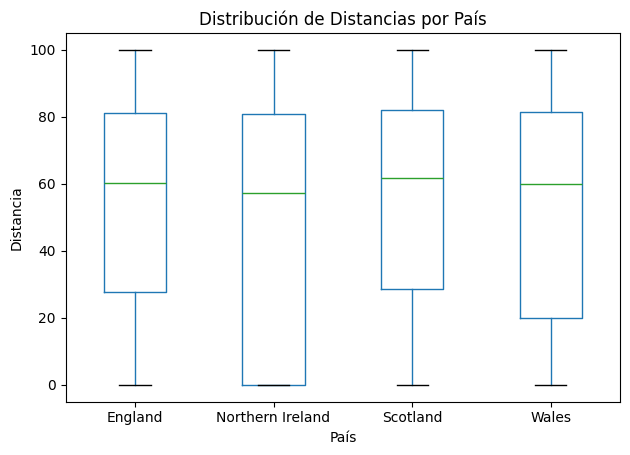

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize=(16, 10))
boxplot = distance_country.to_pandas().boxplot(
    column='distance', by='country', grid=False, 
    showfliers=True
    )
    
plt.title('Distribución de Distancias por País')
plt.suptitle('')
plt.xlabel('País')
plt.ylabel('Distancia')

plt.tight_layout()
plt.show()
plt.savefig('../imgs/distancias_pais_boxplot.png', dpi=300)

# Datos Enriquecidos

Agragaremos los datos de coordenadas, y lo desnormalizaremos para guardarlo en una sola tabla.

In [27]:
enriched_query = """
    SELECT 
        rc.latitude,
        rc.longitude,
        rc.file_path as source_file,
        pd.postcode,
        pd.country,
        pd.region,
        cp.distance,
        COALESCE(el.error_type, '') as error_type,
        COALESCE(cp.created_at, el.created_at) as processed_at
    FROM raw_coordinates rc
    LEFT JOIN coordinates_postcodes cp ON rc.id = cp.coordinate_id
    LEFT JOIN postcode_details pd ON cp.postcode_id = pd.id
    LEFT JOIN error_logs el ON rc.id = el.coordinate_id
    ORDER BY processed_at
"""

In [28]:
enriched_data = pl.read_database(enriched_query, conn)

In [29]:
enriched_data.write_csv("../data/postcode_enriched_data.csv")

In [30]:
conn.close()